# Soil Treatments

In [1]:
import os
import sys
sys.path.append("./src")
import h5py
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from das_util import compute_misfit, get_tstamp
from scipy.ndimage import gaussian_filter1d, zoom
from scipy.interpolate import interp1d

matplotlib.rcParams.update({'font.size': 20})
plt.rcParams['font.family'] = 'Helvetica'

Essential information

In [2]:
### Path and processed data
data_dir='./data/'
fig_dir='./figures/'
spatial_data = os.path.join(data_dir, 'interp_dv_tillage_tire.csv')

### Metadata
freqmin=25
freqmax=50
samp_freq = 500
dchan = 3.19

## Data 

### Data 1 -- dV/V

In [3]:
# with h5py.File(os.path.join(data_dir, 'final_peaks_deRatio_3iterations.h5'), 'r') as f:
#     deratio_dvv = f['deratio_dvv'][:]

with h5py.File(os.path.join(data_dir, 'final_peaks_deRatio__highpassACF.h5'), 'r') as f:
    deratio_dvv = f['deratio_dvv'][:]

interp_f = interp1d(np.arange(0,2408,5), deratio_dvv, axis=-1, bounds_error=False, fill_value="extrapolate")
interp_dvv = interp_f(np.arange(2408))
amp = gaussian_filter1d(interp_dvv, sigma=4, axis=-1)  ## smooth time series

In [4]:
with h5py.File('/Users/shiqibin/projects/data_farm/data/autocorr_15_90Hz_bandpassed.hdf5', 'r') as f:
    v_points = f['v_points'][:]

v_points = v_points + 1
ref_v = 1/v_points[:, 4]
v_points = v_points / (v_points[:, 4][:, np.newaxis])


### Data 2 -- PSD for raining time

In [5]:
### PSD of high frequency DAS
with h5py.File(os.path.join(data_dir, 'integrated_psd.hdf5'), 'r') as f:
    int_PSD = f['int_PSD'][:]
    freq = f['freq'][:]
    file_list = f['file_list'][:]

## Mean PSD over channels
ave_psd=np.mean(int_PSD[0:44]/3, axis=0) + 0.0003
acqu_time = np.array([get_tstamp(i) for i in file_list.astype('U')])

### Index on the hour
# hourly_index = [7,67,127,187,247,299,359,419,466,526,586,646,706,766,826,886,946,1003,1063,1123,
#          1183,1243,1302,1362,1422,1482,1542,1599,1659,1719,1779,1839,1899,1959,2019,
#          2078,2138,2198,2258,2318]
# hourly_index = np.array(hourly_index)
# Ind6hrs = [7, 359, 706, 1063, 1422, 1779, 2138]

# xax=hourly_index[19:27]
# tax=acqu_time[hourly_index[19:27]]
# hrax=[dt.strftime('%H:%M') for dt in tax]

### Data 3 -- Tillage and Compaction from table

In [7]:
#### Block 4 is missing, and use three-plot width as the spare the width
tillage = np.array([5,5,5,   10, 0, 25, 0, 10, 25, 25, 0, 10,    0,0,0,    
                             25, 25, 0, 0, 0, 10, 10, 10, 25,    0,0,0,   
                             10, 10, 0, 0, 10, 25, 0, 25, 25])
tire = np.array([50,50,50,  70, 70, 135, 70, 135, 70, 70, 135, 70,    0,0,0,     
                            135, 70, 70, 135, 70, 135, 70, 70, 70,    0,0,0,    
                            135, 70, 70, 135, 70, 70, 70, 70, 135])
traffic_ratio = np.array([1,1,1,   65, 45, 75, 30, 65, 30, 75,45, 30,    0,0,0,    
                                  75, 30, 45, 45, 30, 65, 65, 30, 75,    0,0,0,   
                                  65, 30, 45, 45, 65, 30, 30, 75, 75])
# tillage = tillage * traffic_ratio

#### Interpolate tillage and tire pressure
f = interp1d(np.arange(36)*3.8+3, tillage, bounds_error=False, fill_value=(1,0))
intep_tillage = f(np.arange(50-6)*dchan)

f = interp1d(np.arange(36)*3.8+3, tire, bounds_error=False, fill_value=(10,0))
intep_tire = f(np.arange(50-6)*dchan)

smooth_tillage = gaussian_filter1d(intep_tillage[:], sigma=2.5)
smooth_tire = gaussian_filter1d(intep_tire[:], sigma=2.5)

## Data 4 -- Porosity

In [8]:
### Porosity
### Read
phy_paras = pd.read_csv(os.path.join(data_dir, 'Soil_phy.csv'))

phy_1 = phy_paras.loc[phy_paras['Plot'].between(1,9)]
phy_2 = phy_paras.loc[phy_paras['Plot'].between(10,18)]
phy_3 = phy_paras.loc[phy_paras['Plot'].between(19,27)]
phy_4 = phy_paras.loc[phy_paras['Plot'].between(28,36)]

phy_1['ind'] = 42 - phy_1['Plot'] 
phy_2['ind'] = 40 - phy_2['Plot']
phy_3['ind'] = 38 - phy_3['Plot']
phy_4['ind'] = 36 - phy_4['Plot']

phy_all = pd.concat([phy_1, phy_2, phy_3, phy_4])
phy_10cm = phy_all.loc[phy_all['Depth (cm)'] == 10]
phy_20cm = phy_all.loc[phy_all['Depth (cm)'] == 20]
phy_30cm = phy_all.loc[phy_all['Depth (cm)'] == 30]


#### Interpolate porosity and bulk density
f = interp1d(np.array(phy_30cm['ind'])*3.8, np.array(phy_30cm['Porosity (%)']), bounds_error=False, fill_value=48)
interp_porosity_30cm = f(np.arange(50)*3.19)

f = interp1d(np.array(phy_20cm['ind'])*3.8, np.array(phy_20cm['Porosity (%)']), bounds_error=False, fill_value=48)
interp_porosity_20cm = f(np.arange(50)*3.19)

f = interp1d(np.array(phy_10cm['ind'])*3.8, np.array(phy_10cm['Porosity (%)']), bounds_error=False, fill_value=48)
interp_porosity_10cm = f(np.arange(50)*3.19)

f = interp1d(np.array(phy_30cm['ind'])*3.8, np.array(phy_30cm['Dry Bulk density (g/cm3)']), bounds_error=False, fill_value=1.35)
interp_bulk_density_30cm = f(np.arange(50)*3.19)

f = interp1d(np.array(phy_20cm['ind'])*3.8, np.array(phy_20cm['Dry Bulk density (g/cm3)']), bounds_error=False, fill_value=1.35)
interp_bulk_density_20cm = f(np.arange(50)*3.19)

f = interp1d(np.array(phy_10cm['ind'])*3.8, np.array(phy_10cm['Dry Bulk density (g/cm3)']), bounds_error=False, fill_value=1.35)   
interp_bulk_density_10cm = f(np.arange(50)*3.19)

interp_data = pd.DataFrame({
    'distance (m)': np.arange(50) * 3.19,
    'interp_porosity_10cm': interp_porosity_10cm,
    'interp_porosity_20cm': interp_porosity_20cm,
    'interp_porosity_30cm': interp_porosity_30cm,
    'interp_bulk_density_10cm': interp_bulk_density_10cm,
    'interp_bulk_density_20cm': interp_bulk_density_20cm,
    'interp_bulk_density_30cm': interp_bulk_density_30cm
})
### Save
save_dir='./data/'
interp_data.to_csv(os.path.join(save_dir, 'interpolated_soil_phy_complete.csv'), index=False)

/var/folders/94/_f91r5t1277f16yl_03mnxkw0000gn/T/ipykernel_17088/1101134743.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phy_1['ind'] = 42 - phy_1['Plot']
/var/folders/94/_f91r5t1277f16yl_03mnxkw0000gn/T/ipykernel_17088/1101134743.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phy_2['ind'] = 40 - phy_2['Plot']
/var/folders/94/_f91r5t1277f16yl_03mnxkw0000gn/T/ipykernel_17088/1101134743.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

## Visualize dV/V

[Text(0, 0, '17'),
 Text(360, 0, '00'),
 Text(720, 0, '06'),
 Text(1080, 0, '12'),
 Text(1440, 0, '18'),
 Text(1800, 0, '00'),
 Text(2160, 0, '06')]

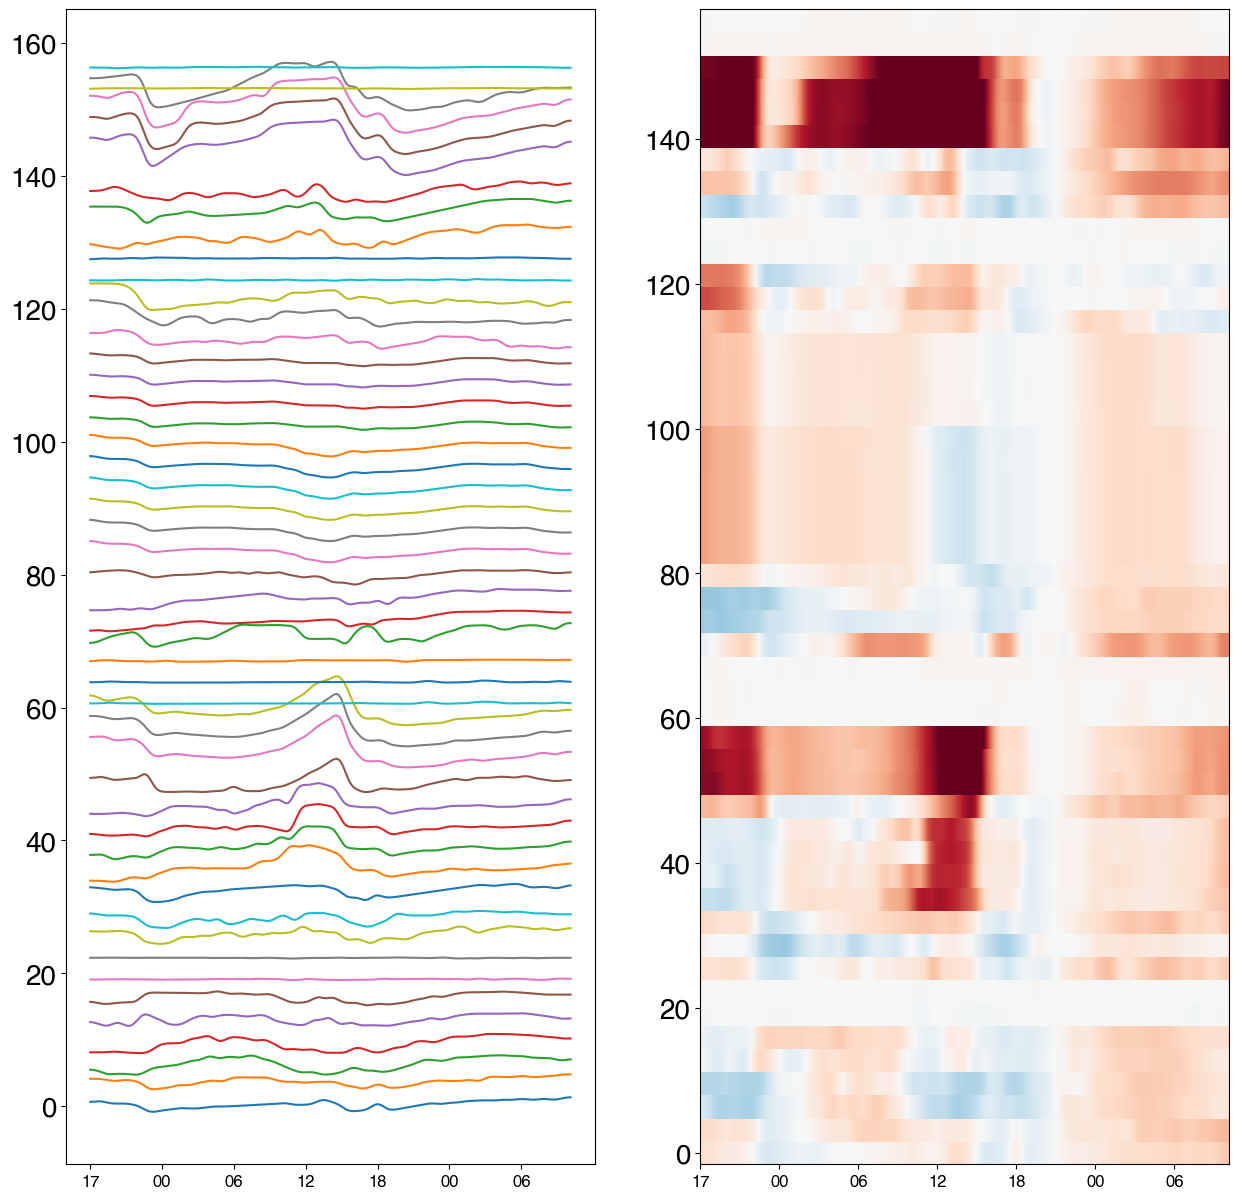

In [6]:
smooth1d_dvv = amp
smooth1d_dvv[26] = smooth1d_dvv[29]
smooth1d_dvv[27] = smooth1d_dvv[29]
smooth1d_dvv[28] = smooth1d_dvv[29]

fig, ax = plt.subplots(1,2, figsize=(15, 15))
for i in range(50):
    ax[0].plot(np.arange(2408), 10*smooth1d_dvv[i]+i*3.19, label=f'channel {i}')

ax[1].pcolor(np.arange(2408), np.arange(50)*3.19, smooth1d_dvv, shading='auto', 
             vmin=-0.5, vmax=0.5, cmap = 'RdBu_r')

xax=np.arange(0, ave_psd.shape[-1], 360)
tax=acqu_time[:ave_psd.shape[-1]:360]
hrax=[dt.strftime('%H') for dt in tax]

ax[0].set_xticks(xax)
ax[0].set_xticklabels(hrax, fontsize = 12)
ax[1].set_xticks(xax)
ax[1].set_xticklabels(hrax, fontsize = 12)

NameError: name 'order1' is not defined

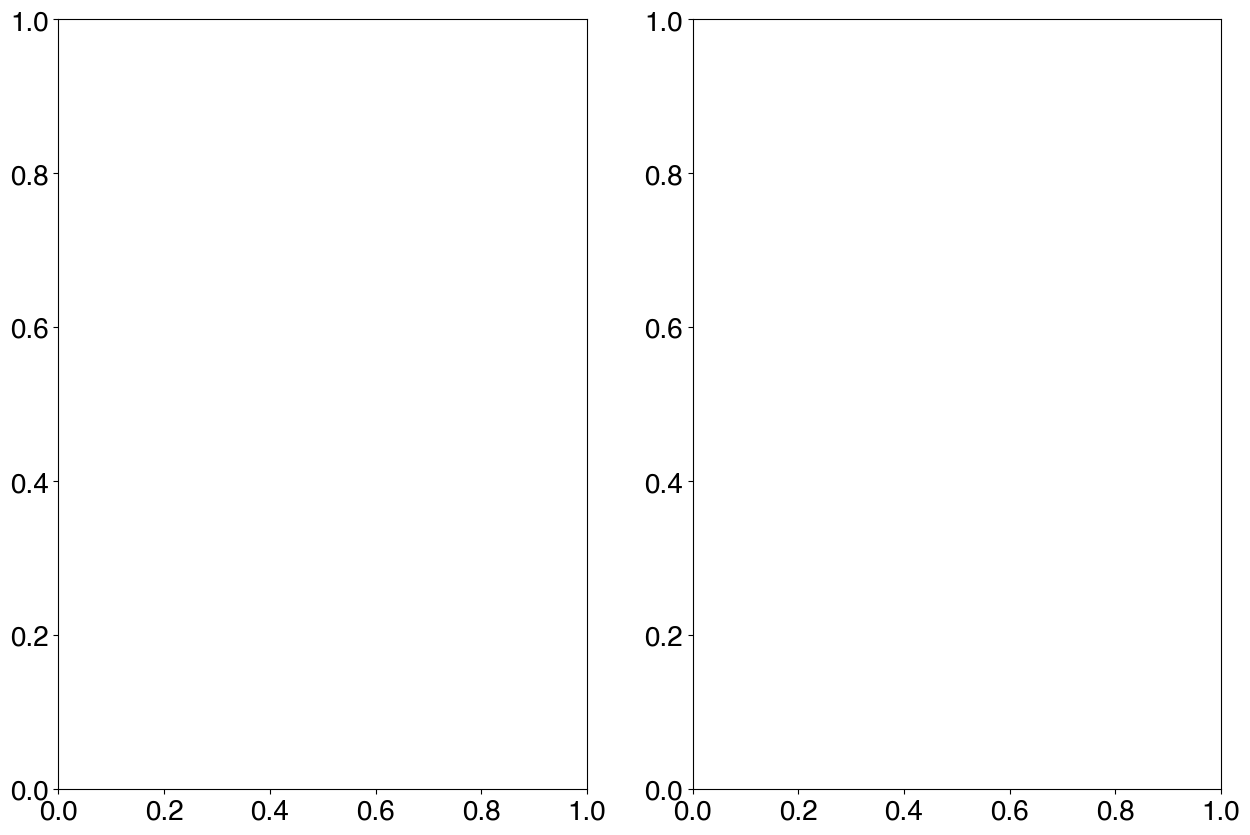

In [10]:
fig, ax = plt.subplots(1,2, figsize=(15, 10))
order = order1 + order2 + order3 + order4 + order5 + order6
for i, loc in enumerate(order):
    ax[0].plot(np.arange(2408), 10*smooth1d_dvv[loc]+i*3.19, label=f'channel {loc}')

ax[1].pcolor(np.arange(2408), np.arange(len(order))*3.19, smooth1d_dvv[order], shading='auto', 
             vmin=-0.5, vmax=0.5, cmap = 'RdBu_r')

xax=np.arange(0, ave_psd.shape[-1], 360)
tax=acqu_time[:ave_psd.shape[-1]:360]
hrax=[dt.strftime('%H') for dt in tax]

ax[0].set_xticks(xax)
ax[0].set_xticklabels(hrax, fontsize = 12)
ax[1].set_xticks(xax)
ax[1].set_xticklabels(hrax, fontsize = 12)

# Sort channels using various matrics

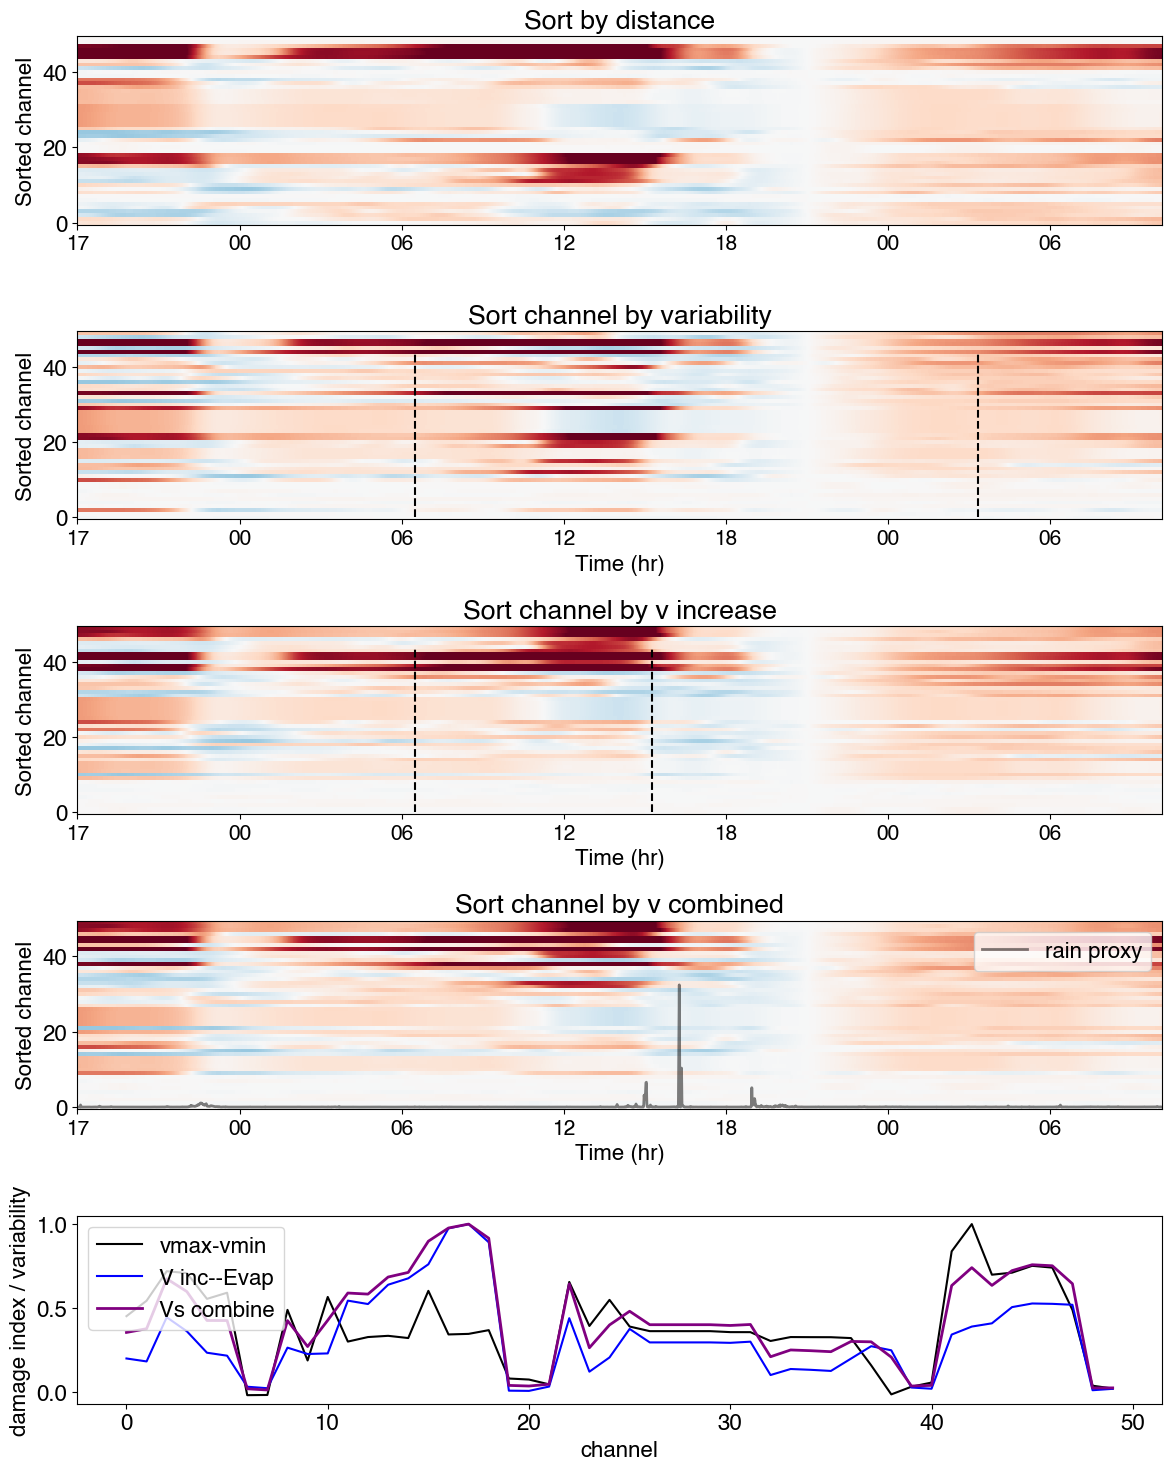

In [ ]:
dvv_all = amp

fig, axs = plt.subplots(5, 1, figsize=(12, 15), tight_layout=True)

# Plot 1: Sort channel distance
axs[0].pcolormesh(np.arange(2408), np.arange(50), dvv_all[:], shading='auto', 
                  vmin=-0.5, vmax=0.5, cmap='RdBu_r')
axs[0].set_title('Sort by distance')
axs[0].set_xticks(xax)
axs[0].set_xticklabels(hrax, fontsize=15)
axs[0].set_ylabel('Sorted channel')

# Plot 2: Sort channel by variability
trim_dvv = dvv_all[0:50, :]
# variability_all = np.nanmax(trim_dvv, axis=1) - np.nanmin(trim_dvv, axis=1)
variability_all = np.mean(trim_dvv[:, 2000:2050], axis=1) - np.mean(trim_dvv[:, 1500:1550], axis=1)  # Example of variability calculation

axs[4].plot(variability_all/np.nanmax(variability_all), color='black', label='vmax-vmin')
variability_indices = np.argsort(variability_all)
axs[1].pcolormesh(np.arange(2408), np.arange(50), dvv_all[variability_indices], 
                  shading='auto', vmin=-0.5, vmax=0.5, cmap='RdBu_r')
axs[1].set_title('Sort channel by variability')
axs[1].set_xticks(xax)
axs[1].set_xticklabels(hrax, fontsize=15)
axs[1].set_xlabel('Time (hr)')
axs[1].set_ylabel('Sorted channel')
axs[1].vlines([750, 2000], 0, 44, color='k', linestyle='--')

# Plot 3: Sort channel by v increase
trim_dvv = dvv_all[0:50, 750:1275]
variability_evap = np.nanmax(trim_dvv, axis=1) - np.nanmin(trim_dvv, axis=1)
axs[4].plot(variability_evap/np.nanmax(variability_evap), color='blue', label='V inc--Evap')
variability_indices = np.argsort(variability_evap)
axs[2].pcolormesh(np.arange(2408), np.arange(50), dvv_all[variability_indices], 
                  shading='auto', vmin=-0.5, vmax=0.5, cmap='RdBu_r')
axs[2].set_title('Sort channel by v increase')
axs[2].set_xticks(xax)
axs[2].set_xticklabels(hrax, fontsize=15)
axs[2].set_xlabel('Time (hr)')
axs[2].set_ylabel('Sorted channel')
axs[2].vlines([750, 1275], 0, 44, color='k', linestyle='--')

# Plot 4: Sort channel by 2+3
variability = variability_all + variability_evap
axs[4].plot(variability/np.nanmax(variability), color='purple', label='Vs combine', lw=2)
variability_indices = np.argsort(variability)
im=axs[3].pcolormesh(np.arange(2408), np.arange(50), dvv_all[variability_indices], 
                     shading='auto', vmin=-0.5, vmax=0.5, cmap='RdBu_r')
axs[3].set_title('Sort channel by v combined')
axs[3].set_xticks(xax)
axs[3].set_xticklabels(hrax, fontsize=15)
axs[3].set_xlabel('Time (hr)')
axs[3].set_ylabel('Sorted channel')
axs[3].plot(ave_psd * 50, color='k', lw=2, alpha=0.5, label='rain proxy')
axs[3].legend()

# Plot 5: all spatial variabilities and damage index
axs[4].set_ylabel('damage index / variability')
axs[4].set_xlabel('channel')
axs[4].legend()

## Grid search Disturbance Index

In [7]:
### Complete treatment data, using point series
sigma = 1
st = 3
ed = 31

#### Complete plot information
tillage = np.array([0,0,0,    25,  25,   0,  25,  10,   0,   0,  10,  10,  
                       25,    25,  10,  10,  10,   0,   0,   0,  25,  25,   
                       10,    10,   0,  25,  25,  10,   0,  25,   0,  10,   
                        0,    10,   0,   0,  25,  25,  10,   0,  10,  25])
compact = np.array([0,0,0,   135,  70,  70,  70,  70, 135,  70,  70, 135,  
                       70,    70,  70,  70, 135,  70, 135,  70,  70, 135,    
                       70,    70, 135,  70,  70, 135,  70, 135,  70,  70,    
                       70,    70, 135,  70, 135,  70, 135,  70,  70,  70])

#### Interpolate tillage and compact pressure
f = interp1d(np.arange(42)*4.4-7.3, tillage[0:42], bounds_error=False, fill_value=0)
interpolate_tillage = f(np.arange(3,53)*dchan)
f = interp1d(np.arange(42)*4.4-7.3, compact[0:42], bounds_error=False, fill_value=0)
interpolate_compact = f(np.arange(4,54)*dchan)

### Smooth the interpolated data
smooth_tillage = gaussian_filter1d(interpolate_tillage[:], sigma=sigma)
smooth_compact = gaussian_filter1d(interpolate_compact[:], sigma=sigma)

In [16]:
### Treatment Information, using a step function
sigma = 1
st = 3
ed = 31

#### Complete plot information
# Convert tillage and compact arrays to step functions
def to_step_function(arr):
    x = np.arange(len(arr))
    x_step = np.repeat(x, 2) + 0.5
    y_step = np.repeat(arr, 2)
    return x_step, y_step

tillage = np.array([0,0,0,    25,  25,   0,  25,  10,   0,   0,  10,  10,  
                       25,    25,  10,  10,  10,   0,   0,   0,  25,  25,   
                       10,    10,   0,  25,  25,  10,   0,  25,   0,  10,   
                        0,    10,   0,   0,  25,  25,  10,   0,  10,  25])
compact = np.array([0,0,0,   135,  70,  70,  70,  70, 135,  70,  70, 135,  
                       70,    70,  70,  70, 135,  70, 135,  70,  70, 135,    
                       70,    70, 135,  70,  70, 135,  70, 135,  70,  70,    
                       70,    70, 135,  70, 135,  70, 135,  70,  70,  70])

tillage_x, tillage_y = to_step_function(tillage)
compact_x, compact_y = to_step_function(compact)

#### Interpolate tillage and compact pressure
f = interp1d(tillage_x*4.4-9.5, tillage_y, bounds_error=False, fill_value=0)
interpolate_tillage = f(np.arange(3,53)*dchan)
f = interp1d(compact_x*4.4-9.5, compact_y, bounds_error=False, fill_value=0)
interpolate_compact = f(np.arange(4,54)*dchan)

### Smooth the interpolated data
smooth_tillage = gaussian_filter1d(interpolate_tillage[:], sigma=sigma)
smooth_compact = gaussian_filter1d(interpolate_compact[:], sigma=sigma)

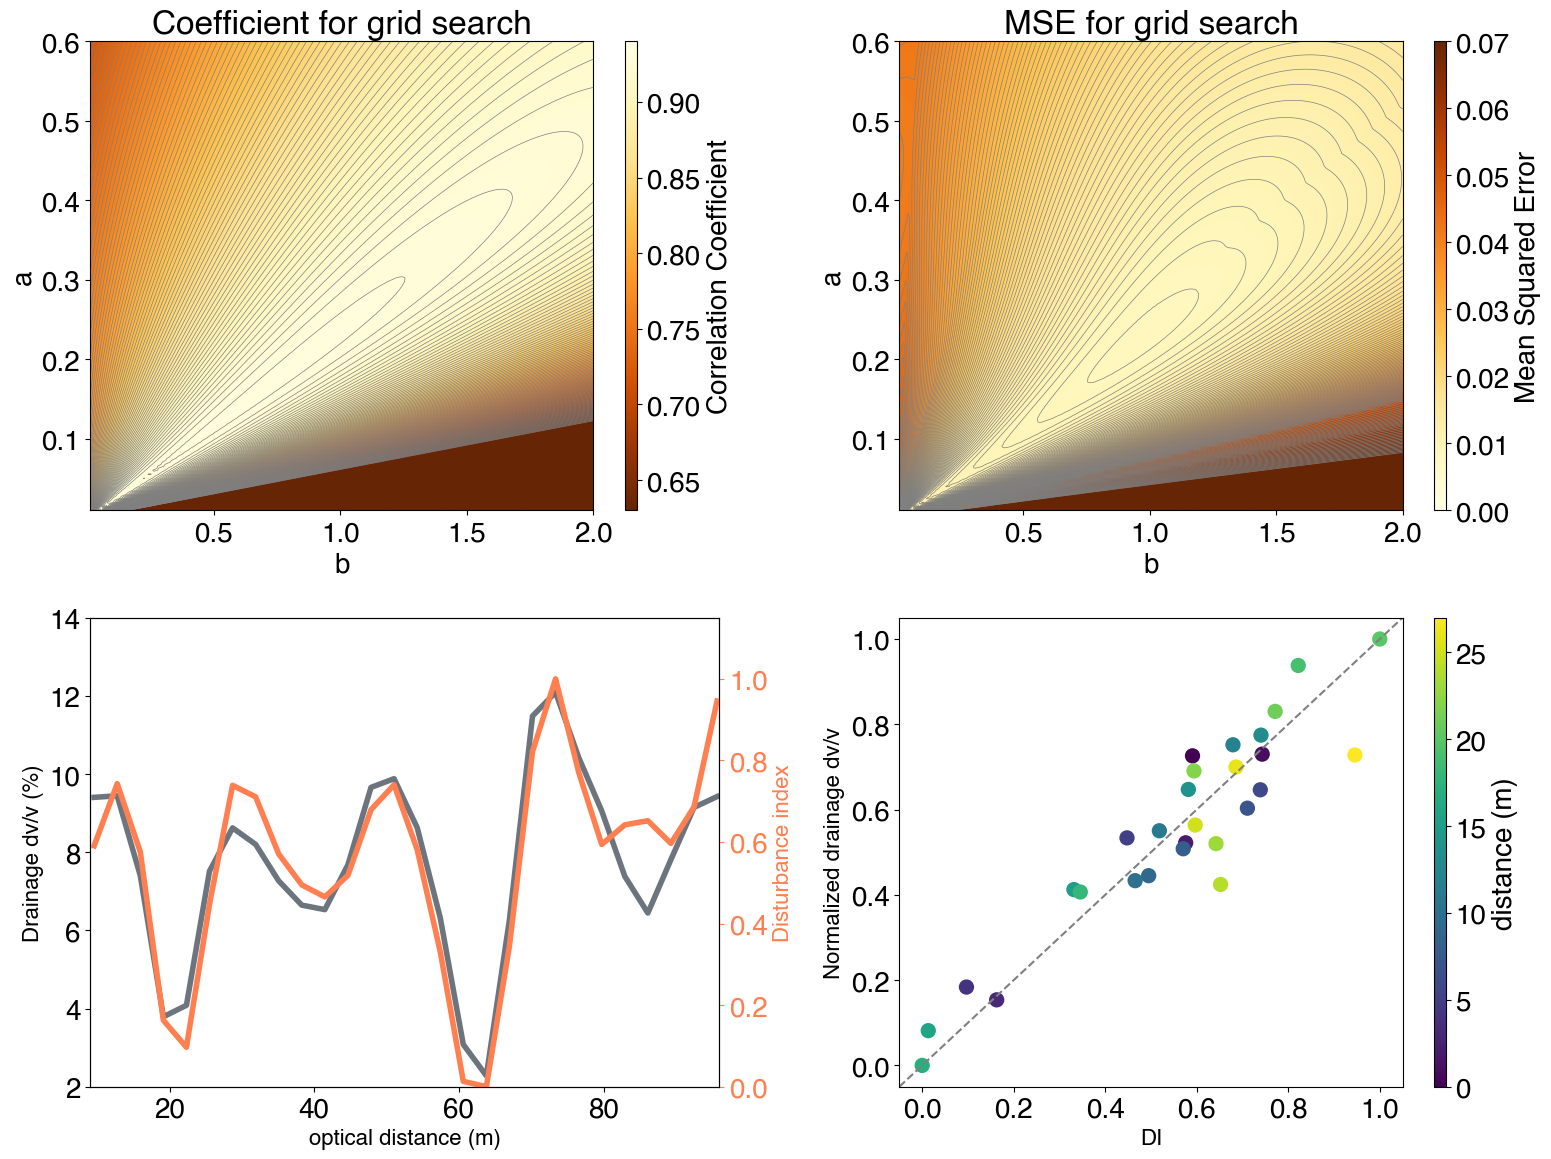

In [87]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12), tight_layout=True)

# Correlation matrix
cax1 = axs[0, 0].imshow(correlation_matrix, extent=[min_value, max_value_b, min_value, max_value_a], 
                        origin='lower', aspect='auto', cmap='YlOrBr_r', vmin=0.63, vmax=0.94)
contour1 = axs[0, 0].contour(correlation_matrix, levels=np.arange(0.63,0.94,0.003), colors='gray', 
                             extent=[min_value, max_value_b, min_value, max_value_a], linewidths=0.5)
fig.colorbar(cax1, ax=axs[0, 0], label='Correlation Coefficient', aspect=40)
axs[0, 0].set_xlabel('b')
axs[0, 0].set_ylabel('a')
axs[0, 0].set_title('Coefficient for grid search')

# MSE matrix
cax2 = axs[0, 1].imshow(mse_matrix, extent=[min_value, max_value_b, min_value, max_value_a], 
                        origin='lower', aspect='auto', cmap='YlOrBr', vmin=0.0, vmax=0.07)
contour2 = axs[0, 1].contour(mse_matrix, levels=np.arange(0.0,0.07,0.0005), colors='gray', 
                             extent=[min_value, max_value_b, min_value, max_value_a], linewidths=0.5)
fig.colorbar(cax2, ax=axs[0, 1], label='Mean Squared Error', aspect=40)
axs[0, 1].set_xlabel('b')
axs[0, 1].set_ylabel('a')
axs[0, 1].set_title('MSE for grid search')

# Spatial variability plot
axs[1, 0].set_xlabel("optical distance (m)", fontsize=16)
axs[1, 0].set_ylabel("Drainage dv/v (%)", fontsize=16)
twinx = axs[1, 0].twinx()

correlation, mse, mae, scaled_mechanical, scaled_variability = compute_misfit(
    best_a_mse, best_b_mse, tillage_interpolated, compact_interpolated, dvv_variability, sigma=0.5)
axs[1, 0].plot((np.arange(len(scaled_variability))+st)*3.19, dvv_variability*100, label='variability', lw=4, color='#6C757D')
twinx.plot((np.arange(len(dvv_variability))+st)*3.19, scaled_mechanical, 
           label='Disturbance index = $T_{till}^{4.8}~C_{tire}^{4.9}$', lw=4, color='Coral')
twinx.set_ylabel("Disturbance index", fontsize=16, color='Coral')
twinx.tick_params(axis='y', colors='Coral')
twinx.set_ylim(0, 1.15)
axs[1, 0].set_ylim(2, 14)
axs[1, 0].set_xlim(9, 96)

# Covariance plot
damage_index = scaled_mechanical
axs[1, 1].plot([0, 1], [0, 1], transform=axs[1, 1].transAxes, color='gray', linestyle='--')
cax = axs[1, 1].scatter(damage_index, scaled_variability, s=100, cmap='viridis', c=(np.arange(len(dvv_variability))))
axs[1, 1].set_ylabel("Normalized drainage dv/v", fontsize=16)
axs[1, 1].set_xlabel("DI", fontsize=16)
fig.colorbar(cax, ax=axs[1, 1], label='distance (m)', aspect=40)

plt.show()


In [11]:
## Stretch the distance axis to improve localization
import scipy.signal as sgn
def stretch(wave1, wave2, time, maxshift=0, min_ratio=1.08, max_ratio=1.2):

    interp_f = interp1d(time, wave2, bounds_error=False, fill_value=0.)
    n1 = np.sum(np.square(wave1))
    dt = time[1] - time[0]
    cc = 0
    relative_ratio = 1

    for ratio in np.arange(min_ratio, max_ratio, 0.01):
        dt_new = dt / ratio
        time_new = np.arange(time[0], time[-1], dt_new)
        wave_new = interp_f(time_new)
        
        n2 = np.sum(np.square(wave_new))
        corr = sgn.correlate(wave1, wave_new) / np.sqrt(n1 * n2)

        l_maxshift = min(len(wave_new), maxshift)
        r_maxshift = min(len(wave1), maxshift)

        st_pt = len(wave_new) - l_maxshift
        en_pt = len(wave_new) + r_maxshift+1

        cc_best = np.nanmax(corr[st_pt: en_pt])

        if cc < cc_best:
            cc = cc_best
            relative_ratio = ratio

    dt_new = dt / relative_ratio
    time_new = np.arange(time[0], time[-1], dt_new)
    wave_new = interp_f(time_new)
    
    
    return wave_new, np.arange(len(wave_new))*dt, relative_ratio, cc


stretched_di, stretched_time, stretched_ratio, stretched_cc = stretch(scaled_variability, scaled_mechanical, 
                                                                      np.arange(st, ed)*3.19, maxshift=20,
                                                                      min_ratio=1.1, max_ratio=1.2)


### use the stretched ratio to stretch smooth_tire and smooth_tillage
zoom_tillage = zoom(smooth_tillage[st:ed], stretched_ratio)
zoom_compact = zoom(smooth_compact[st:ed], stretched_ratio)


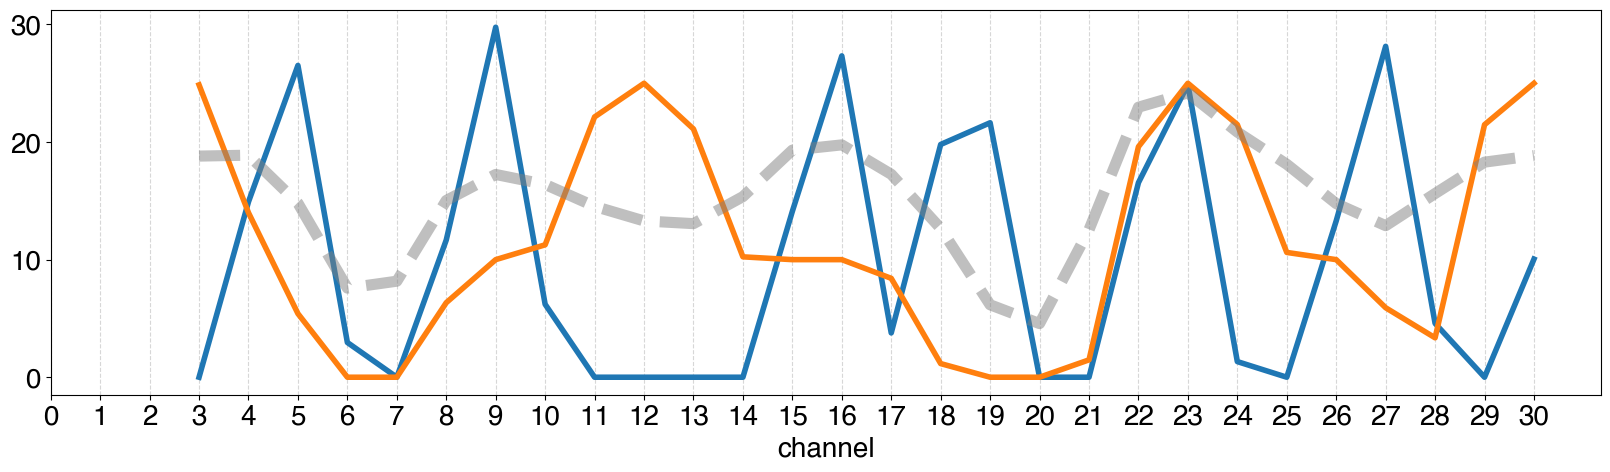

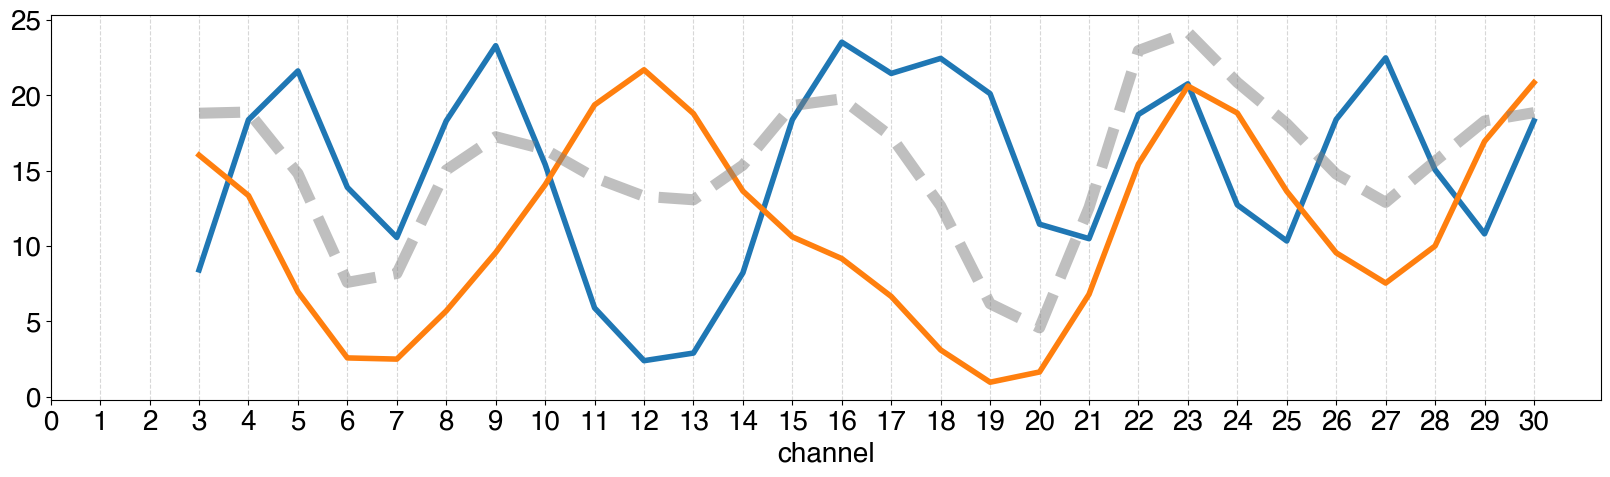

In [30]:
# Not smoothed
plt.figure(figsize=(20, 5))
plt.plot(np.arange(st,ed),interpolate_compact[st:ed]/2-35, lw=4)
plt.plot(np.arange(st,ed),interpolate_tillage[st:ed], lw=4)
plt.plot(np.arange(st,ed),dvv_variability[:ed-st]*200, color='gray', 
         linestyle='--', label='variability', lw=8, alpha=0.5)

plt.xticks(np.arange(0, ed, 1))

plt.xlabel('channel')
plt.grid(axis='x', which='both', linestyle='--', alpha=0.5)

# Smoothed
plt.figure(figsize=(20, 5))
plt.plot(np.arange(st,ed),smooth_compact[st:ed]/1.5-45, lw=4)
plt.plot(np.arange(st,ed),smooth_tillage[st:ed], lw=4)
plt.plot(np.arange(st,ed),dvv_variability[:ed-st]*200, color='gray', 
         linestyle='--', label='variability', lw=8, alpha=0.5)

plt.xticks(np.arange(0, ed, 1))

plt.xlabel('channel')
plt.grid(axis='x', which='both', linestyle='--', alpha=0.5)


/var/folders/94/_f91r5t1277f16yl_03mnxkw0000gn/T/ipykernel_8630/2873164158.py:56: RuntimeWarning: divide by zero encountered in scalar divide
  ratio1[0] = ratio1[0] + interpolate_compact[loc] / interpolate_tillage[loc]


Text(0.05, 0.7, 'B')

/Users/shiqibin/miniconda3/envs/quakeflow/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/Users/shiqibin/miniconda3/envs/quakeflow/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


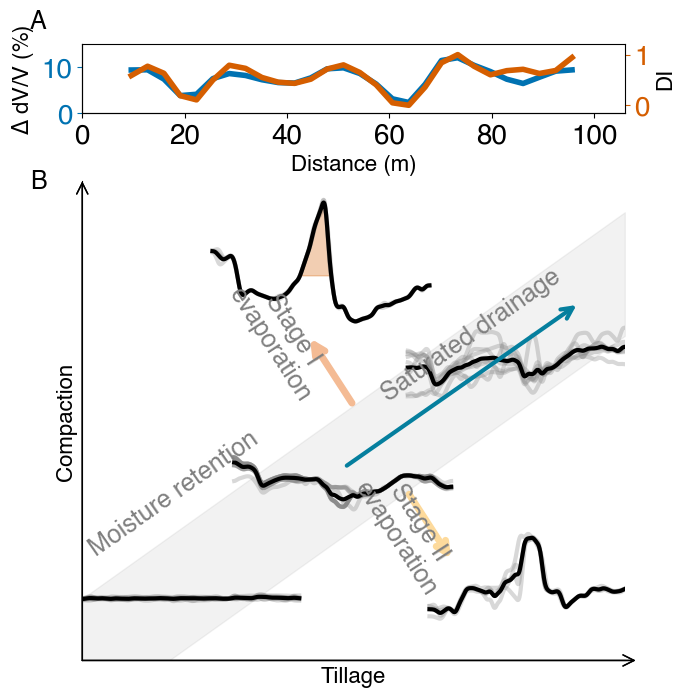

In [31]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(7, 8), tight_layout=True)
gs = gridspec.GridSpec(5, 3, figure=fig, wspace=1, hspace=1)
ax0 = fig.add_subplot(gs[0:1, 0:3]) 
ax1 = fig.add_subplot(gs[1:5, 0:3])


correlation, mse, mae, scaled_mechanical, scaled_variability = compute_misfit(best_a_mae, best_b_mae, 
                                                                              tillage_interpolated, 
                                                                              compact_interpolated, 
                                                                              dvv_variability) 
disturbance_index = scaled_mechanical

ax0.plot(np.arange(st,ed)*3.19, dvv_variability*100, label='variability', lw=4, color='#0072B2')
ax0.set_xlabel("Distance (m)", fontsize=16)
ax0.set_ylabel("$\Delta$ dV/V (%)", fontsize=16)
ax0.tick_params(axis='y', colors='#0072B2')
ax0.set_xlim(0, 106)
ax0.set_ylim(0, 15)

twinx = ax0.twinx() 
twinx.plot(np.arange(st,ed) * 3.19, disturbance_index, lw=4, color='#D55E00')  
twinx.set_ylabel("DI", fontsize=16, color='k')
twinx.tick_params(axis='y', colors='#D55E00')
twinx.set_ylim(-0.15, 1.2)


order1 = [6,7,19,20,21,39,40,48,49]
order2 = [11,12,13,14]
order4 = [26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 25]
order5 = [1,0,8,10,9, 22,23,24]
order6 = [16, 17, 18]

offset = 0
ratio1 = np.zeros(6)
ratio2 = np.zeros(6)

# Plot a diagonal line across ax1
# Shade a diagonal area across ax1
x = np.array([0, 2408 * 2.5])
y1 = np.array([0, 250])
y2 = y1 - 80  # adjust thickness of shaded area as needed
ax1.fill_between(x, y1, y2, color='gray', alpha=0.1)
ax1.set_ylim(-40, 270)
ax1.set_xlim(0, 2408 * 2.5)

locations = [[0,0],[1.6,0],[0.7,0.7],[1.5,1.5],[0.6,1.8]]
# Helper function to plot mean curve for a group
def plot_mean_curve(ax, group, location, color='k', label=None):
    mean_curve = np.mean(smooth1d_dvv[group], axis=0)
    ax.plot(np.arange(2408) + location[0]*2408, 100*mean_curve + location[1]*100, color=color, lw=3, label=label)

for i, loc in enumerate(order1):
    ax1.plot(np.arange(2408)+locations[0][0]*2408, 100*smooth1d_dvv[loc]+i*offset+locations[0][1]*100, color='gray', alpha=0.3, lw=3)
    ratio1[0] = ratio1[0] + interpolate_compact[loc] / interpolate_tillage[loc]
    ratio2[0] = ratio2[0] + smooth_compact[loc] / smooth_tillage[loc]
ratio1[0] = ratio1[0] / len(order1)
ratio2[0] = ratio2[0] / len(order1)
plot_mean_curve(ax1, order1, locations[0])

for i, loc in enumerate(order2):
    ax1.plot(np.arange(2408)+locations[1][0]*2408, 100*smooth1d_dvv[loc]+i*offset+locations[1][1]*100, color='gray', alpha=0.3, lw=3)
    ratio1[1] = ratio1[1] + interpolate_compact[loc] / interpolate_tillage[loc]
    ratio2[1] = ratio2[1] + smooth_compact[loc] / smooth_tillage[loc]
ratio1[1] = ratio1[1] / len(order1)
ratio2[1] = ratio2[1] / len(order1)
plot_mean_curve(ax1, order2, locations[1])

for i, loc in enumerate(order4):
    ax1.plot(np.arange(2408)+locations[2][0]*2408, 100*smooth1d_dvv[loc]+i*offset+locations[2][1]*100, color='gray', alpha=0.3, lw=3)
    ratio1[3] = ratio1[3] + interpolate_compact[loc] / interpolate_tillage[loc]
    ratio2[3] = ratio2[3] + smooth_compact[loc] / smooth_tillage[loc]
ratio1[3] = ratio1[3] / len(order1)
ratio2[3] = ratio2[3] / len(order1)
plot_mean_curve(ax1, order4, locations[2])

for i, loc in enumerate(order5):
    ax1.plot(np.arange(2408)+locations[3][0]*2408, 100*smooth1d_dvv[loc]+i*offset+locations[3][1]*100, color='gray', alpha=0.3, lw=3)
    ratio1[4] = ratio1[4] + interpolate_compact[loc] / interpolate_tillage[loc]
    ratio2[4] = ratio2[4] + smooth_compact[loc] / smooth_tillage[loc]
ratio1[4] = ratio1[4] / len(order1)
ratio2[4] = ratio2[4] / len(order1)
plot_mean_curve(ax1, order5, locations[3])

for i, loc in enumerate(order6):
    ax1.plot(np.arange(2408)+locations[4][0]*2408, 100*smooth1d_dvv[loc]+i*offset+locations[4][1]*100, color='gray', alpha=0.3, lw=3)
    
    ratio1[5] = ratio1[5] + interpolate_compact[loc] / interpolate_tillage[loc]
    ratio2[5] = ratio2[5] + smooth_compact[loc] / smooth_tillage[loc]

ax1.fill_between(
        np.arange(2408)+locations[4][0]*2408, 100*smooth1d_dvv[loc]+i*offset+locations[4][1]*100,
        np.max(40*smooth1d_dvv[loc])+i*offset+locations[4][1]*100,
        where=((100 * smooth1d_dvv[loc] > np.max(40 * smooth1d_dvv[loc])) & (np.arange(2408) > 900)),
        color='#D55E00', alpha=0.3, label='Dynamic\ncapillary\npressure' if i == 0 else None
    )
ratio1[5] = ratio1[5] / len(order1)
ratio2[5] = ratio2[5] / len(order1)
plot_mean_curve(ax1, order6, locations[4])

ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])

# Remove the top and right spines (frame lines) for both axes
for ax in [ax0, ax1]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add arrows for the left and bottom frame lines on ax1
    arrowprops = dict(arrowstyle='->', linewidth=1, color='k', shrinkA=0, shrinkB=0)

    # Left (y) axis arrow
    ax1.annotate('', xy=(0, 270), xytext=(0, -40), arrowprops=arrowprops, annotation_clip=False)

    # Bottom (x) axis arrow
    ax1.annotate('', xy=(2408 * 2.55, -40), xytext=(0, -40), arrowprops=arrowprops, annotation_clip=False)

ax1.set_ylabel('Compaction', fontsize=16)
ax1.set_xlabel('Tillage', fontsize=16)
# Add an arrow pointing to the upper left at the middle of ax1, thick and orange
mid_x = (ax1.get_xlim()[1] - ax1.get_xlim()[0]) / 2
mid_y = (ax1.get_ylim()[1] - ax1.get_ylim()[0]) / 2 -30
ax1.annotate(
    '', 
    xy=(mid_x - 500, mid_y + 45), 
    xytext=(mid_x, mid_y), 
    arrowprops=dict(arrowstyle='->', linewidth=5, color="#F4BB94", alpha=1),
    annotation_clip=False
)
ax1.text(
    mid_x - 800, mid_y + 0, 
    "Stage I\nevaporation", 
    fontsize=18, color='gray', rotation=-57, ha='center', va='bottom'
)

ax1.annotate(
    '', 
    xy=(mid_x + 500 + 600, mid_y - 45 - 56), 
    xytext=(mid_x+600, mid_y-56), 
    arrowprops=dict(arrowstyle='->', linewidth=5, color="#FDDA9C", alpha=1),
    annotation_clip=False
)
ax1.text(
    mid_x + 600, mid_y - 125, 
    "Stage II\nevaporation", 
    fontsize=18, color='gray', rotation=-57, ha='center', va='bottom'
)

ax1.annotate(
    '', 
    xy=(mid_x + 2500, mid_y + 66), 
    xytext=(mid_x-100, mid_y-40), 
    arrowprops=dict(arrowstyle='->', linewidth=3, color="#057F9EB8", alpha=1),
    annotation_clip=False
)
ax1.text(
    mid_x + 1300, mid_y - 0, 
    "Saturated drainage", 
    fontsize=18, color='gray', rotation=35, ha='center', va='bottom'
)

ax1.text(
    mid_x -2000, mid_y - 100, 
    "Moisture retention", 
    fontsize=18, color='gray', rotation=35, ha='center', va='bottom'
)

fig.text(0.05, 0.9, 'A', fontsize= 18)
fig.text(0.05, 0.7, 'B', fontsize=18)

In [32]:
tire = smooth_compact 
tillage = smooth_tillage 
offset_x = 2408*2/ 15
offset_y = 100/ 30
amplify = 30 / offset_y

min_tillage = np.min(tillage[st:ed])
max_tillage = np.max(tillage[st:ed])
min_tire = np.min(tire[st:ed])
max_tire = np.max(tire[st:ed])

di = np.power(tillage[st:ed], best_a_mse) * np.power(tire[st:ed], best_b_mse)
di_min = np.power(min_tillage, best_a_mse) * np.power(min_tire, best_b_mse)
di_max = np.power(max_tillage, best_a_mse) * np.power(max_tire, best_b_mse)
di = di - di_min
di = di / (di_max - di_min)

/var/folders/94/_f91r5t1277f16yl_03mnxkw0000gn/T/ipykernel_8630/3363583303.py:148: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('soil_regimes.pdf', dpi=300, bbox_inches='tight')
/var/folders/94/_f91r5t1277f16yl_03mnxkw0000gn/T/ipykernel_8630/3363583303.py:148: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('soil_regimes.pdf', dpi=300, bbox_inches='tight')
/Users/shiqibin/miniconda3/envs/quakeflow/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


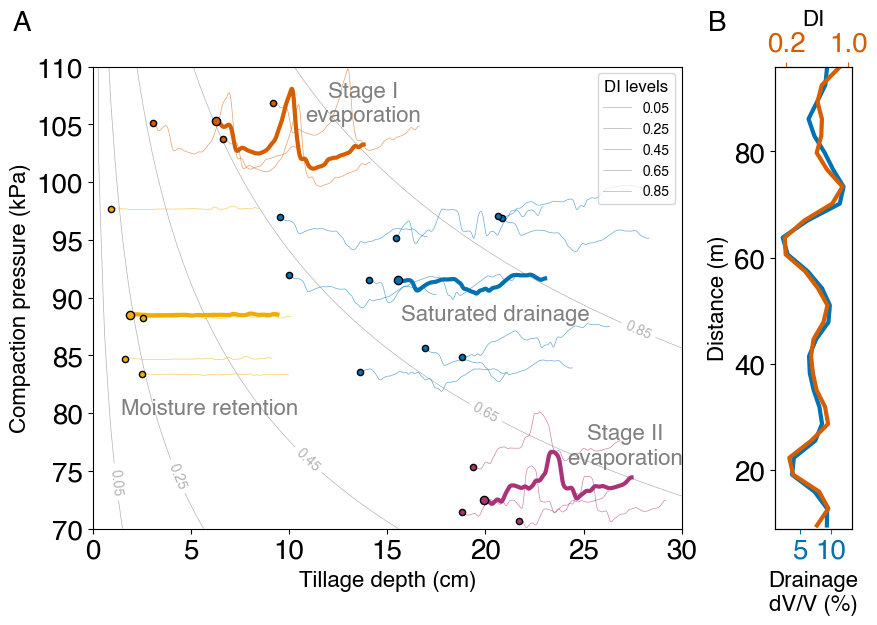

In [77]:
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(12, 6), tight_layout=True)
gs = gridspec.GridSpec(3, 6, figure=fig, wspace=1.2, hspace=1)
ax1 = fig.add_subplot(gs[0:3, 1:5]) 
ax0 = fig.add_subplot(gs[0:3, 5:6])


ax0.plot(dvv_variability*100, np.arange(st,ed)*3.19, label='variability', lw=3, color='#0072B2')
ax0.set_ylabel("Distance (m)", fontsize=16)
ax0.set_xlabel("Drainage\ndV/V (%)", fontsize=16)
ax0.tick_params(axis='x', colors='#0072B2')
ax0.set_ylim(9, 96)
ax0.set_xlim(1, 13.5)

twiny = ax0.twiny() 
twiny.plot(di, np.arange(st,ed)*3.19, lw=3, color='#D55E00')  
twiny.set_xlabel("DI", fontsize=16, color='k')
twiny.tick_params(axis='x', colors='#D55E00')
twiny.set_xlim(0.05, 1.05)
twiny.set_xticks([0.2, 1.0])



order1 = [6, 7, 19, 20]
order2 = [11, 12, 13]
order4 = [25, 26, 28, 29, 30, 10, 22, 23, 24]
order6 = [16, 17, 18]


# Helper function to plot mean curve for a group
def plot_mean_curve(ax, group, color='k', label=None):
    mean_curve = np.mean(smooth1d_dvv[group], axis=0)
    ax.plot(np.arange(2408) / offset_x + np.mean(tillage[group]), amplify*mean_curve + np.mean(tire[group]), color=color, lw=3, label=label)
    ax.scatter(np.mean(tillage[group]), amplify*mean_curve[0]+np.mean(tire[group]), color=color, s=35, edgecolor='k', zorder=5)

ax1.set_xlim(0, 30)
ax1.set_ylim(70, 110)

# Plot contour of x^0.21 * y^0.91
x_grid = np.linspace(ax1.get_xlim()[0], ax1.get_xlim()[1], 100)
y_grid = np.linspace(ax1.get_ylim()[0], ax1.get_ylim()[1], 100)
X, Y = np.meshgrid(x_grid, y_grid)
Z = X**best_a_mse * Y**best_b_mse
Z = Z - di_min
Z = Z / (di_max - di_min)

levels = np.linspace(0.05, 0.85, 5)  # Define contour levels
positions = [(1,74), (5, 75), (11, 76), (20, 80), (28,88)]
contour = ax1.contour(X, Y, Z, levels=levels, colors='black', alpha=0.3, linewidths=0.5, zorder=0)
ax1.clabel(contour, inline=True, fontsize=10, fmt='%.2f', manual=positions)
# Create proxy lines for legend
legend_lines = [Line2D([0], [0], color='black', linestyle='-', linewidth=0.5, alpha=0.3, label=f'{lvl:.2f}') for lvl in levels]
# Add legend
# Create the legend as usual
legend = ax1.legend(handles=legend_lines, title='DI levels', loc='upper right', fontsize=10, title_fontsize=12)


for i, loc in enumerate(order1):
    ax1.plot(np.arange(2408)/offset_x + tillage[loc], amplify*smooth1d_dvv[loc]+tire[loc], color='#F0AD00', alpha=0.6, lw=0.5)
    ax1.scatter(tillage[loc], amplify*smooth1d_dvv[loc][0]+tire[loc], color='#F0AD00', s=20, edgecolor='k', zorder=5)
    # ax1.text(
    #     np.arange(2408)[-1] + tillage[loc]*2408*2 + 10,
    #     amplify*smooth1d_dvv[loc][-1] + tire[loc]*100,
    #     str(loc),
    #     color='red',
    #     fontsize=10,
    #     va='center'
    # )
plot_mean_curve(ax1, order1, color='#F0AD00')

for i, loc in enumerate(order2):
    ax1.plot(np.arange(2408)/offset_x + tillage[loc], amplify*smooth1d_dvv[loc]+tire[loc], color='#AA3377', alpha=0.6, lw=0.5)
    ax1.scatter(tillage[loc], amplify*smooth1d_dvv[loc][0]+tire[loc], color='#AA3377', s=20, edgecolor='k', zorder=5)
    # ax1.text(
    #     np.arange(2408)[-1] + tillage[loc]*2408*2 + 10,
    #     amplify*smooth1d_dvv[loc][-1] + tire[loc]*100,
    #     str(loc),
    #     color='blue',
    #     fontsize=10,
    #     va='center'
    # )
plot_mean_curve(ax1, order2, color='#AA3377')

for i, loc in enumerate(order4):
    ax1.plot(np.arange(2408)/offset_x + tillage[loc], amplify*smooth1d_dvv[loc]+tire[loc], color='#0072B2', alpha=0.6, lw=0.5)
    ax1.scatter(tillage[loc], amplify*smooth1d_dvv[loc][0]+tire[loc], color='#0072B2', s=20, edgecolor='k', zorder=5)
    # ax1.text(
    #     np.arange(2408)[-1] + tillage[loc]*2408*2 + 10,
    #     amplify*smooth1d_dvv[loc][-1] + tire[loc]*100,
    #     str(loc),
    #     color='gray',
    #     fontsize=10,
    #     va='center'
    # )
plot_mean_curve(ax1, order4, color='#0072B2')


for i, loc in enumerate(order6):
    ax1.plot(np.arange(2408)/offset_x + tillage[loc], amplify*smooth1d_dvv[loc]+tire[loc], color='#D55E00', alpha=0.6, lw=0.5)
    ax1.scatter(tillage[loc], amplify*smooth1d_dvv[loc][0]+tire[loc], color='#D55E00', s=20, edgecolor='k', zorder=5)
    # ax1.text(
    #     np.arange(2408)[-1] + tillage[loc]*2408*2 + 10,
    #     amplify*smooth1d_dvv[loc][-1] + tire[loc]*100,
    #     str(loc),
    #     color='orange',
    #     fontsize=10,
    #     va='center'
    # )

# ax1.fill_between(
#         np.arange(2408)+tillage[loc]*2408, 100*smooth1d_dvv[loc]+i*offset+tire[loc]*100,
#         np.max(40*smooth1d_dvv[loc])+i*offset+tire[loc]*100,
#         where=((100 * smooth1d_dvv[loc] > np.max(40 * smooth1d_dvv[loc])) & (np.arange(2408) > 900)),
#         color='#D55E00', alpha=0.3, label='Dynamic\ncapillary\npressure' if i == 0 else None
#     )

plot_mean_curve(ax1, order6, color='#D55E00')

ax1.text(
    np.mean(tillage[order1])+1300/offset_x, np.mean(tire[order1])-30/offset_y, 
    "Moisture retention", 
    fontsize=16, color='gray', ha='center', va='bottom'
)
ax1.text(
    np.mean(tillage[order4])+1600/offset_x, np.mean(tire[order4])-11/offset_y, 
    "Saturated drainage", 
    fontsize=16, color='gray', ha='center', va='bottom'
)
ax1.text(
    np.mean(tillage[order2])+2300/offset_x, np.mean(tire[order2])+7/offset_y, 
    "Stage II\nevaporation", 
    fontsize=16, color='gray', ha='center', va='bottom'
)
ax1.text(
    np.mean(tillage[order6])+2400/offset_x, np.mean(tire[order6])+12/offset_y, 
    "Stage I\nevaporation", 
    fontsize=16, color='gray', ha='center', va='bottom'
)

ax1.set_ylabel('Compaction pressure (kPa)', fontsize=16)
ax1.set_xlabel('Tillage depth (cm)', fontsize=16)

fig.text(0.20, 0.94, 'A', fontsize=20)
fig.text(0.78, 0.94, 'B', fontsize=20)

plt.savefig('soil_regimes.pdf', dpi=300, bbox_inches='tight')

In [94]:
dyn_type = np.where(dvv_variability > 0.55, 0, np.where(dvv_variability > 0.30, 1, 2))

## Save the damage index
interp_paras = pd.DataFrame(data={'dvv_variability': variability_all,
                                  'dvv_variability_evap': variability_evap,
                                  'disturbance_index': damage_index,
                                  'tillage_depth': smooth_tillage,
                                  'tire_pressure': smooth_tire,
                                  'dyn_type': dyn_type})

interp_paras.to_csv(os.path.join(data_dir, 'damage_index.csv'))

NameError: name 'variability_all' is not defined

## FIGURE 3

/var/folders/94/_f91r5t1277f16yl_03mnxkw0000gn/T/ipykernel_17630/3106246337.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(fig_dir, 'disturbance.pdf'), dpi=300)
/var/folders/94/_f91r5t1277f16yl_03mnxkw0000gn/T/ipykernel_17630/3106246337.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(fig_dir, 'disturbance.pdf'), dpi=300)
/Users/shiqibin/miniconda3/envs/quakeflow/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


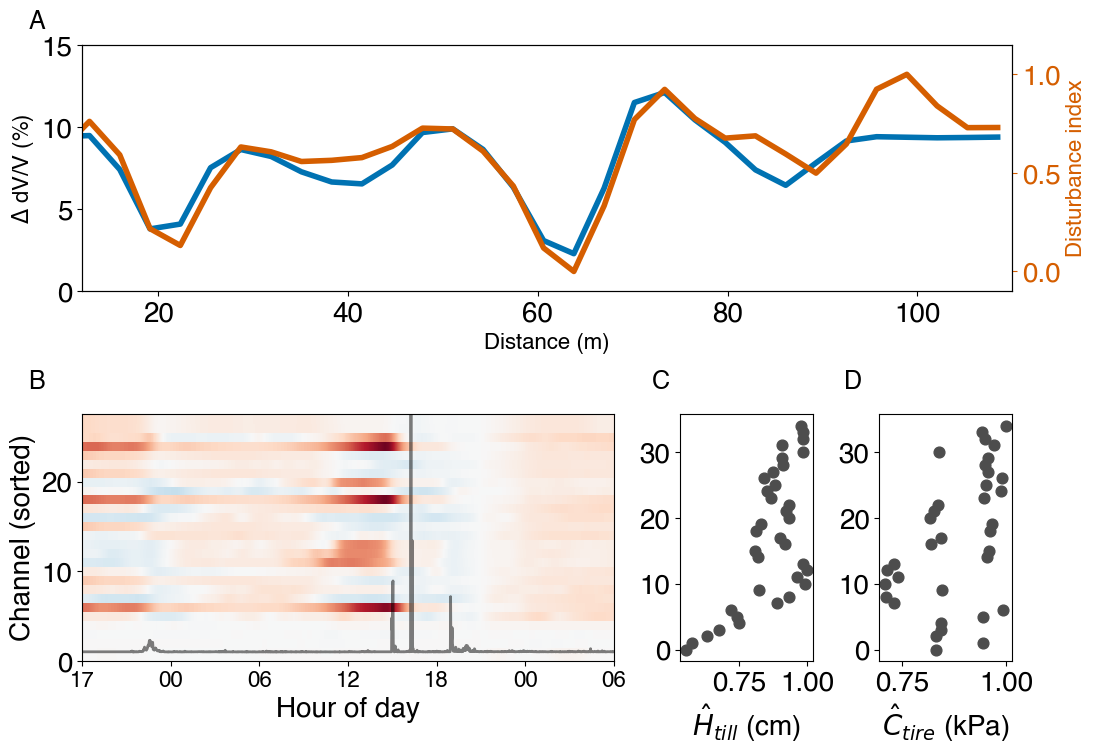

In [170]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 8), tight_layout=True)
gs = gridspec.GridSpec(2, 5, figure=fig, wspace=0.5, hspace=0.5)
ax1 = fig.add_subplot(gs[0, 0:5]) 
ax3 = fig.add_subplot(gs[1, 0:3])
ax4 = fig.add_subplot(gs[1, 3])
ax5 = fig.add_subplot(gs[1, 4])

correlation, mse, mae, scaled_mechanical, scaled_variability = compute_misfit(best_a_mae, best_b_mae, 
                                                                              tillage_interpolated, 
                                                                              tire_interpolated, 
                                                                              dvv_variability) 
disturbance_index = scaled_mechanical

trim_dvv_smooth1d = amp[st:ed, 1105:1500]
variability_indices = np.argsort(disturbance_index) + st

### (a) Vs variability and Disturbance Index
# ax1.fill_between([0,200], [0,0], [30,30], color='#E4F5EC', alpha=1)
# ax1.fill_between([0,200], [30,30], [55,55], color='#FFF9DC', alpha=1)
# ax1.fill_between([0,200], [55,55], [80,80], color='#FDE3E1', alpha=1)
ax1.plot(np.arange(st,ed)*3.19, dvv_variability*100, label='variability', lw=4, color='#0072B2')
ax1.set_xlabel("Distance (m)", fontsize=16)
ax1.set_ylabel("$\Delta$ dV/V (%)", fontsize=16)
ax1.set_xlim(12, 110)
ax1.set_ylim(0, 15)

twinx = ax1.twinx() 
twinx.plot(np.arange(st,ed)*3.19, disturbance_index, lw=4, color='#D55E00')  
twinx.set_ylabel("Disturbance index", fontsize=16, color='#D55E00')
twinx.tick_params(axis='y', colors='#D55E00')
twinx.set_ylim(-0.1, 1.15)

### (b) DI sorted dvv
ave_psd[1190:1258] = 0 
ave_psd[:200] = 0 
im = ax3.pcolor(np.arange(2408), np.arange(ed-st), amp[variability_indices], shading='auto', vmin=-0.8, vmax=0.8, cmap='RdBu_r')
ax3.plot(ave_psd * 60 + 1, color='k', lw=2, alpha=0.5, label='rain proxy')
ax3.set_xlabel('Hour of day')
ax3.set_ylabel('Channel (sorted)')
ax3.set_xlim([1105,1500])
ax3.set_ylim(0, 27.5)
ax3.set_xticks(xax)
ax3.set_xticklabels(hrax, fontsize=16)

### (c) DI sorted tillage
ax4.scatter(tillage_interpolated[variability_indices-st]**0.2, np.arange(ed-st), s=60, color='#4D4D4D')
ax4.set_xlabel('$\hat{H}_{till}$ (cm)')

### (d) DI sorted tire pressure
ax5.scatter(tire_interpolated[variability_indices-st]**0.91, np.arange(ed-st), s=60, color='#4D4D4D')
ax5.set_xlabel('$\hat{C}_{tire}$ (kPa)')

fig.text(0.08, 0.9, 'A', fontsize= 18)
fig.text(0.08, 0.45, 'B', fontsize=18)
fig.text(0.60, 0.45, 'C', fontsize=18)
fig.text(0.76, 0.45, 'D', fontsize=18)

plt.savefig(os.path.join(fig_dir, 'disturbance.pdf'), dpi=300)

## Additional data -- attenuation

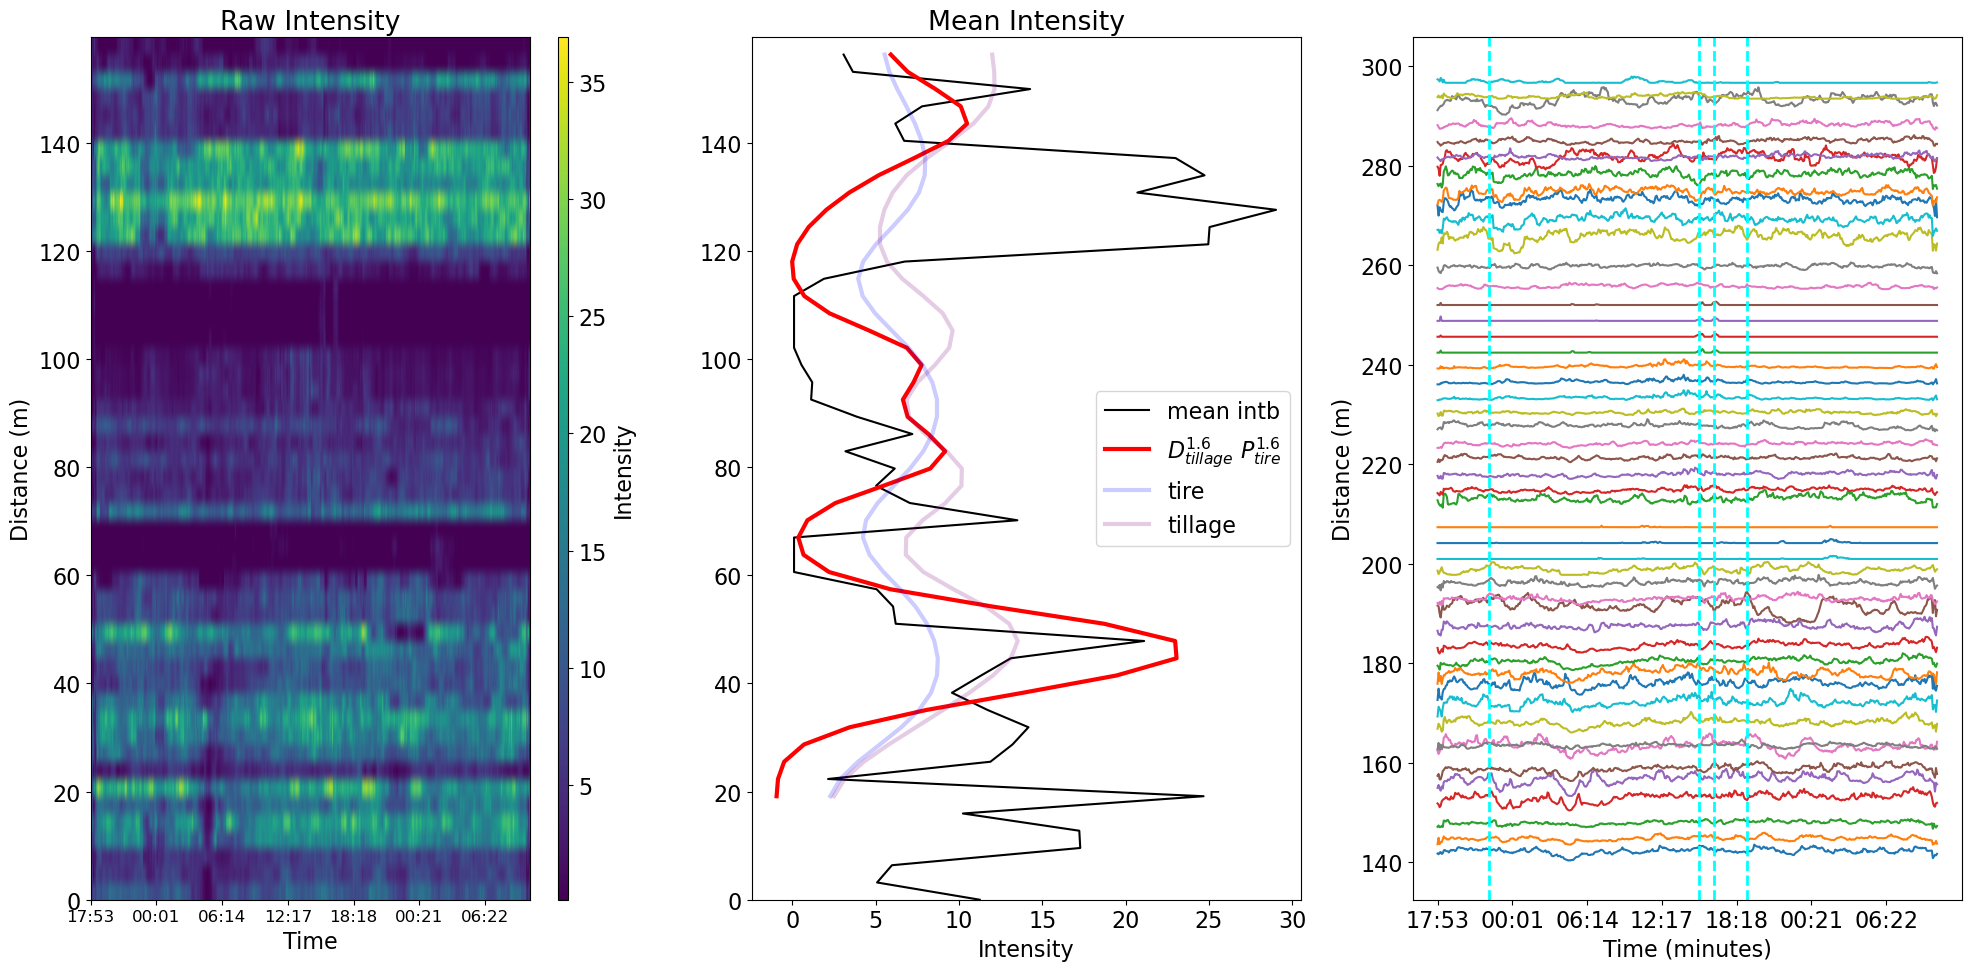

In [ ]:
with h5py.File(os.path.join(data_dir, 'Result_intb_15-60Hz_stretched_twice.h5'), 'r') as f:
    raw_intb = f['raw_intb'][:]
    demean_intb = f['demean_intb'][:]
    abs_intb = f['absintb'][:]
    mean_acf_intb=f['mean_acf_intb'][:]

trim_inb = raw_intb[:, 221:300]
variability = np.fabs(np.nanmean(trim_inb[:, :30], axis=1) - np.nanmean(trim_inb[:, -30:], axis=1))


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

# Plot raw_intb
cax1 = ax1.imshow(raw_intb[:, :, 0], aspect='auto', cmap='viridis', origin='lower', extent=[0, 2408, 0, 50*3.19])
ax1.set_title('Raw Intensity')
ax1.set_xlabel('Time')
ax1.set_ylabel('Distance (m)')
ax1.set_xticks(xax)
ax1.set_xticklabels([t.strftime('%H:%M') for t in tax], fontsize=12)
fig.colorbar(cax1, ax=ax1, orientation='vertical', label='Intensity', aspect=80)

# Plot demean_intb
# ax2.plot(mean_acf_intb, np.arange(50)*3.19, label='mean acf intb', color='k')
# ax2.plot(variability, np.arange(50)*3.19, label='intb_variability', color='green')
ax2.plot(np.mean(raw_intb[:, 30:42, 0], axis=1), np.arange(50)*3.19, color='k', label='mean intb')
# ax2.plot(abs_intb, np.arange(50)*3.19, label='intb_variability', color='green')
ax2.plot(scaled_mechanical*6-1, np.arange(6, 50)*3.19, label='$D_{tillage}^{1.6}~P_{tire}^{1.6}$', lw=3, color='red')  
ax2.plot(smooth_tire, np.arange(6, 50)*3.19, label='tire', lw=3, color='blue', alpha=0.2)
ax2.plot(smooth_tillage, np.arange(6, 50)*3.19, label='tillage', lw=3, color='purple', alpha=0.2)
ax2.legend()

ax2.set_title('Mean Intensity')
ax2.set_xlabel('Intensity')
ax2.set_ylim([0, 50*3.19])

for i in range(50):
    ax3.plot(np.arange(482)*5, raw_intb[i, :, 0]/5+(i+44)*3.19)
ax3.axvline(x=250,  color='cyan', linestyle='--', lw=2)
ax3.axvline(x=1260,  color='cyan', linestyle='--', lw=2)
ax3.axvline(x=1330,  color='cyan', linestyle='--', lw=2)
ax3.axvline(x=1490,  color='cyan', linestyle='--', lw=2)
ax3.set_xlabel('Time (minutes)')
ax3.set_ylabel('Distance (m)')
ax3.set_xticks(xax)
ax3.set_xticklabels([t.strftime('%H:%M') for t in tax], fontsize=16)

plt.tight_layout()